# ✅Uplift-деревья

## ⭐ Импорты

In [1]:
import numpy as np
import pandas as pd
from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from upninja.models.Trees.UpliftTreeClassifier import UpliftTreeClassifier
from upninja.models.Trees.UpliftTreeClassifierDML import UpliftTreeClassifierDML

# causalml
from causalml.inference.tree import UpliftTreeClassifier as UpliftTreeClassifierCM
from causalml.metrics import plot_gain

from sklift.metrics import qini_auc_score, uplift_at_k

import matplotlib.pyplot as plt

/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Failed to import duecredit due to No module named 'duecredit'


In [2]:
SEED = 42

## ⭐ Hilstrom

In [3]:
data = fetch_hillstrom(target_col='visit')
df = data.data
X, y, w = df, data.target, data.treatment

# Hillstrom: treatment — 'Mens E-Mail', 'Womens E-Mail' -> объединим в бинарный treatment
w = (w != 'No E-Mail').astype(int)  # 1 — получили email, 0 — нет

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=SEED
)

num_cols = X_train.select_dtypes(exclude='object').columns
X_train = X_train[num_cols]
X_test = X_test[num_cols]

# for causalml
X_train_np, X_test_np, y_train_np, y_test_np, w_train_str, w_test_str = (
    X_train.values, X_test.values,
    y_train.values, y_test.values,
    np.where(w_train == 1, 'treatment', 'control'),
    np.where(w_test == 1, 'treatment', 'control')
)

In [4]:
df.shape

(64000, 8)

In [5]:
%%time

tree_dml = UpliftTreeClassifierDML(
    min_samples=100,
    max_depth=5,
    min_samples_treatment=5,
    random_state=SEED
)

tree_dml.fit(X_train, y_train, w_train)
pred_tree_dml = tree_dml.predict(X_test)

CPU times: user 97.3 ms, sys: 5.39 ms, total: 103 ms
Wall time: 101 ms


In [6]:
%%time

causalml_tree = UpliftTreeClassifierCM(
    max_depth=5,
    min_samples_leaf=100,
    random_state=SEED,
    control_name='control'
)

causalml_tree.fit(X_train_np, w_train_str, y_train_np)
pred_causalml_tree = causalml_tree.predict(X_test_np)[:, 0]

CPU times: user 88.3 ms, sys: 3.68 ms, total: 91.9 ms
Wall time: 90.6 ms


In [7]:
print("=== Сравнение по метрикам uplift (деревья) ===")
print(f"Upninja DML Tree — Qini AUC: {qini_auc_score(y_test, pred_tree_dml, w_test):.4f}")
print(f"Causalml Tree — Qini AUC: {qini_auc_score(y_test_np, pred_causalml_tree.flatten(), w_test):.4f}")

print(f"\nUplift@30%:")
print(f"Upninja DML Tree: {uplift_at_k(y_test, pred_tree_dml, w_test, strategy='by_group', k=0.3):.4f}")
print(f"Causalml: {uplift_at_k(y_test_np, pred_causalml_tree.flatten(), w_test, strategy='by_group', k=0.3):.4f}")

print(f"\nСредний uplift:")
print(f"Upninja DML Tree: {pred_tree_dml.mean():.4f}")
print(f"Causalml: {pred_causalml_tree.mean():.4f}")

=== Сравнение по метрикам uplift (деревья) ===
Upninja DML Tree — Qini AUC: 0.0520
Causalml Tree — Qini AUC: 0.0468

Uplift@30%:
Upninja DML Tree: 0.0941
Causalml: 0.1035

Средний uplift:
Upninja DML Tree: 0.0586
Causalml: 0.1072


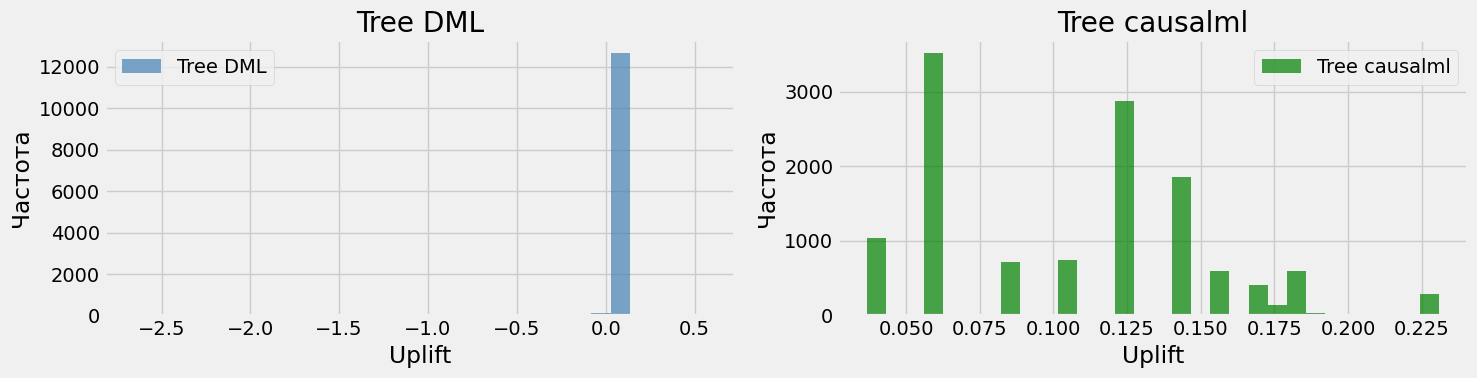

In [8]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(pred_tree_dml, bins=30, alpha=0.7, color='steelblue', label='Tree DML')
plt.title('Tree DML')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(pred_causalml_tree, bins=30, alpha=0.7, color='green', label='Tree causalml')
plt.title('Tree causalml')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
results = pd.DataFrame({
    'tree_dml': pred_tree_dml,
    'causalml': pred_causalml_tree
})

actual_treatment = np.where(w_test == 1, 'treatment', 'control')
is_control = (actual_treatment == 'control').astype(int)

gain_df_tree_dml = pd.DataFrame({
    'conversion': y_test.to_numpy(),
    'is_treated': 1 - is_control,
    'uplift': results['tree_dml']
})

gain_df_causalml = pd.DataFrame({
    'conversion': y_test.to_numpy(),
    'is_treated': 1 - is_control,
    'uplift': results['causalml']
})

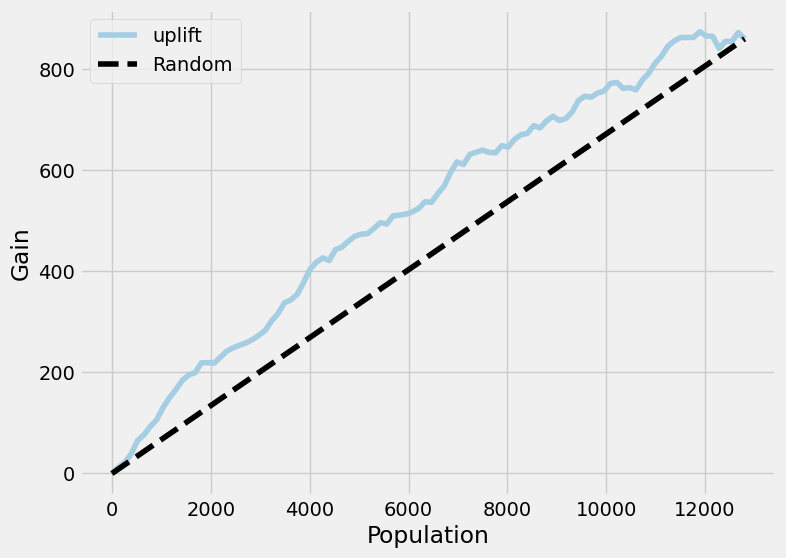

In [10]:
plot_gain(gain_df_tree_dml,
          outcome_col='conversion',
          treatment_col='is_treated',
          figsize=(8, 6))

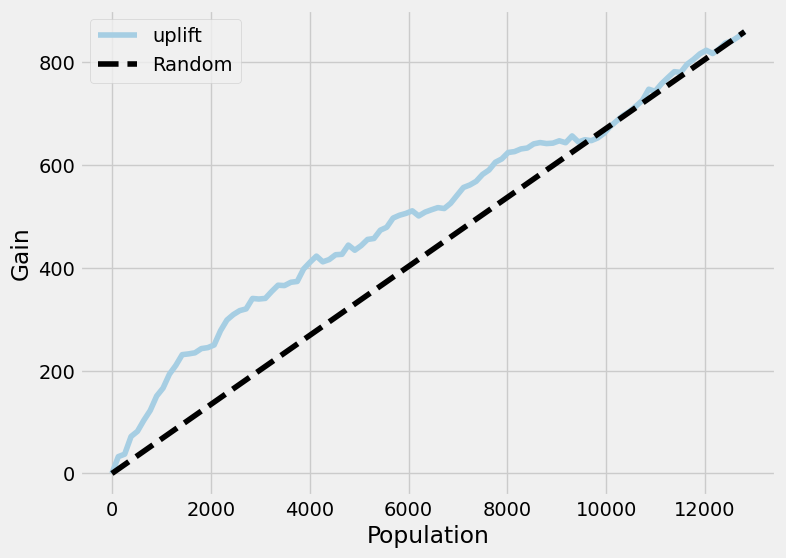

In [11]:
plot_gain(gain_df_causalml,
          outcome_col='conversion',
          treatment_col='is_treated',
          figsize=(8, 6))

## ⭐ Criteo Uplift Prediction Dataset

In [1]:
import numpy as np
import pandas as pd
from sklift.datasets import fetch_criteo
from sklearn.model_selection import train_test_split

from upninja.models.Trees.UpliftTreeClassifier import UpliftTreeClassifier
from upninja.models.Trees.UpliftTreeClassifierDML import UpliftTreeClassifierDML

# causalml
from causalml.inference.tree import UpliftTreeClassifier as UpliftTreeClassifierCM
from causalml.metrics import plot_gain

from sklift.metrics import qini_auc_score, uplift_at_k

import matplotlib.pyplot as plt

/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Failed to import duecredit due to No module named 'duecredit'


In [2]:
SEED = 42

In [3]:
data = fetch_criteo()
df = data.data
X, y, w = df, data.target, data.treatment

w = w.astype(int)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=SEED, stratify=w
)

num_cols = X_train.select_dtypes(exclude='object').columns
X_train = X_train[num_cols]
X_test = X_test[num_cols]

# for causalml
X_train_np, X_test_np, y_train_np, y_test_np, w_train_str, w_test_str = (
    X_train.values, X_test.values,
    y_train.values, y_test.values,
    np.where(w_train == 1, 'treatment', 'control'),
    np.where(w_test == 1, 'treatment', 'control')
)

In [4]:
df.shape

(13979592, 12)

In [5]:
%%time

tree_dml = UpliftTreeClassifierDML(
    min_samples=100,
    max_depth=4,
    min_samples_treatment=5,
    random_state=SEED
)

tree_dml.fit(X_train, y_train, w_train)
pred_tree_dml = tree_dml.predict(X_test)

CPU times: user 22.1 s, sys: 1.21 s, total: 23.4 s
Wall time: 23.9 s


In [6]:
%%time

causalml_tree = UpliftTreeClassifierCM(
    max_depth=4,
    min_samples_leaf=100,
    random_state=SEED,
    control_name='control'
)

causalml_tree.fit(X_train_np, w_train_str, y_train_np)
pred_causalml_tree = causalml_tree.predict(X_test_np)[:, 0]

CPU times: user 17.3 s, sys: 720 ms, total: 18 s
Wall time: 18.1 s


In [7]:
print("=== Сравнение по метрикам uplift (деревья) ===")
print(f"Upninja DML Tree — Qini AUC: {qini_auc_score(y_test, pred_tree_dml, w_test):.4f}")
print(f"Causalml Tree — Qini AUC: {qini_auc_score(y_test_np, pred_causalml_tree.flatten(), w_test):.4f}")

print(f"\nUplift@30%:")
print(f"Upninja DML Tree: {uplift_at_k(y_test, pred_tree_dml, w_test, strategy='by_group', k=0.3):.4f}")
print(f"Causalml: {uplift_at_k(y_test_np, pred_causalml_tree.flatten(), w_test, strategy='by_group', k=0.3):.4f}")

print(f"\nСредний uplift:")
print(f"Upninja DML Tree: {pred_tree_dml.mean():.4f}")
print(f"Causalml: {pred_causalml_tree.mean():.4f}")

=== Сравнение по метрикам uplift (деревья) ===
Upninja DML Tree — Qini AUC: 0.0807
Causalml Tree — Qini AUC: 0.0614

Uplift@30%:
Upninja DML Tree: 0.0302
Causalml: 0.0260

Средний uplift:
Upninja DML Tree: 0.0080
Causalml: 0.0388


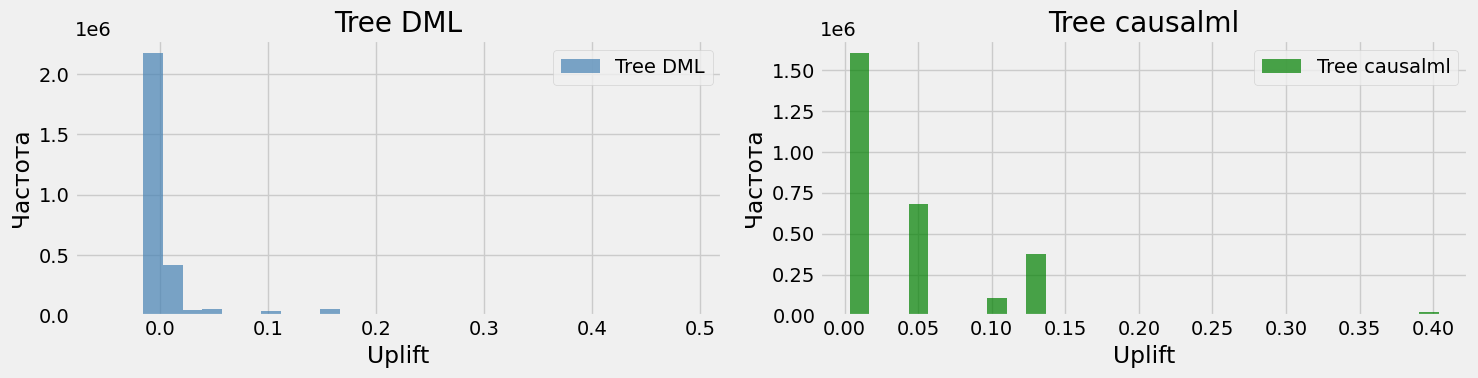

In [8]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(pred_tree_dml, bins=30, alpha=0.7, color='steelblue', label='Tree DML')
plt.title('Tree DML')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(pred_causalml_tree, bins=30, alpha=0.7, color='green', label='Tree causalml')
plt.title('Tree causalml')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
results = pd.DataFrame({
    'tree_dml': pred_tree_dml,
    'causalml': pred_causalml_tree
})

actual_treatment = np.where(w_test == 1, 'treatment', 'control')
is_control = (actual_treatment == 'control').astype(int)

gain_df_tree_dml = pd.DataFrame({
    'conversion': y_test.to_numpy(),
    'is_treated': 1 - is_control,
    'uplift': results['tree_dml']
})

gain_df_causalml = pd.DataFrame({
    'conversion': y_test.to_numpy(),
    'is_treated': 1 - is_control,
    'uplift': results['causalml']
})

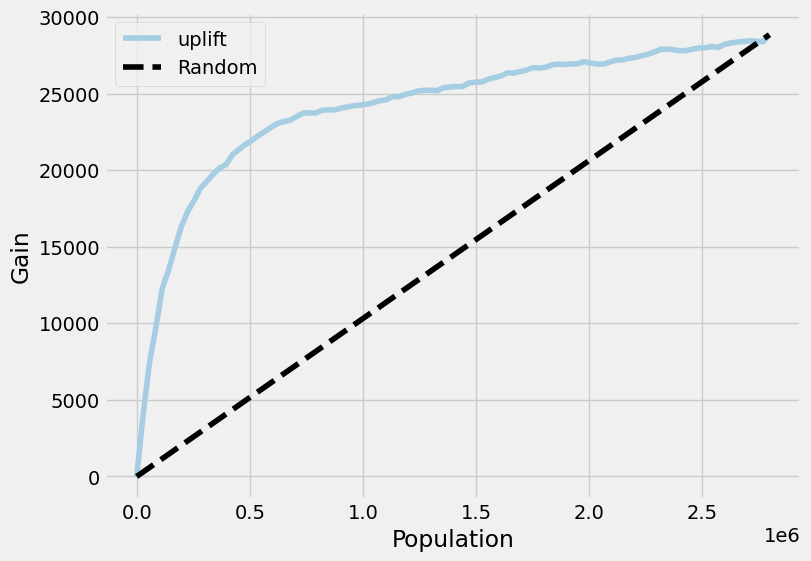

In [10]:
plot_gain(gain_df_tree_dml,
          outcome_col='conversion',
          treatment_col='is_treated',
          figsize=(8, 6))

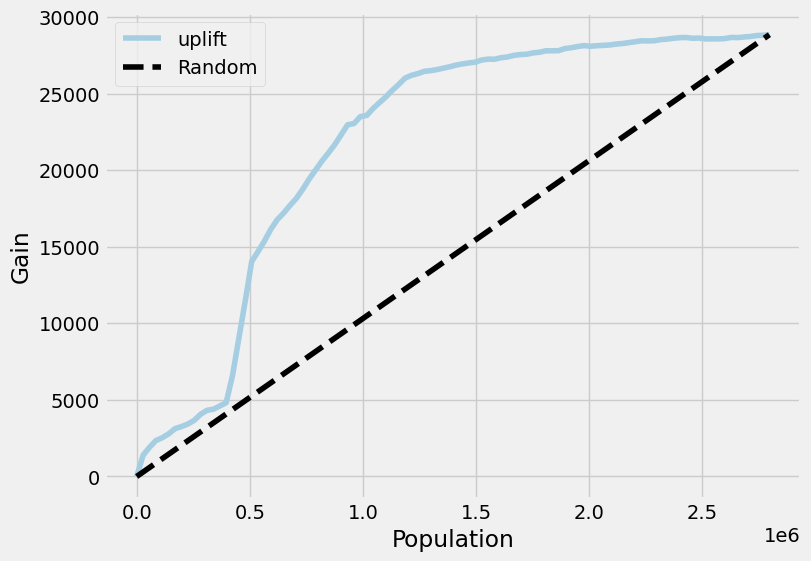

In [11]:
plot_gain(gain_df_causalml,
          outcome_col='conversion',
          treatment_col='is_treated',
          figsize=(8, 6))